In [1]:
# !pip install -e ../package/
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
from thesispack.models import Rnn
from thesispack.datasets import ZeroShotDataset
from thesispack.methods import pca_denoising_preprocessing, pca_denoising_figure, print_confmtx, history_figure
from sklearn.neighbors import KNeighborsClassifier
# from tensorboard.plugins import projector
import os

In [3]:
embs_id = '32'
embsD = 32

dz = ZeroShotDataset(embs_id)
labels = ['0','1','2']
# all combinations seen (s), unseen (u):
# {s: ['0','1'], u:['2']}, {s: ['0','2'], u:['1']}, {s: ['1','2'], u:['0']}
seen_labels = ['0','2']
unseen_labels = ['1']
outfilekey = 's-{}-u-{}'.format('-'.join(seen_labels), '-'.join(unseen_labels))

dz.load_data(seen_labels,unseen_labels)

knn = KNeighborsClassifier(1)
r_emb = dz.get_r_embs_dict()
X = tf.concat([r_emb[label].reshape(1,-1) for label in labels],axis=0)
Xall = tf.concat([r_emb[key].reshape(1,-1) for key in r_emb.keys()],axis=0)
labels_all = list(r_emb.keys())
Y = dz.get_r_onehot_from_labels([label for label in labels])
knn.fit(X,Y)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
for x, _,y, y1 in dz.train:
    x = x.numpy()[np.where(
        np.logical_and(
            (y.numpy()==[1,0,0]).sum(axis=1)==3,
            (y1.numpy()==[0,1]).sum(axis=1)==2
        ))]
    for i in range(x.shape[0]):
        plt.figure(figsize=(8,2.5))
        plt.plot(x[i],'-o')
        plt.xlabel(r'$time(s)$')
        plt.ylabel(r'$Normalized\; UDP\; Throughput$')
        plt.show()
        break
    break

In [4]:
es = {'es_strategy':'first_drop', 'es_metric':'harmonic_score'}

# add outfilekey as weights_outfile
rnn = Rnn(embsD, knn, es, weights_outfile=None, optimizer="Adam", learning_rate=1e-3)

In [7]:
rnn.train(dz.train, 100,dz.val,dz.test, history_learning_process=True)
# rnn.load_weights("../weights/weights_best_{}.tf".format(outfilekey))

Epoch 4 finished
train_cost: 0.3815329074859619, train_score: 0.5
val_cost: 0.37843820452690125, val_score: 0.5
test_cost: 0.30455684661865234, test_score: 1.0
harmonic score: 0.6666666865348816
Epoch 5 finished
train_cost: 0.35314685106277466, train_score: 0.5
val_cost: 0.3498520851135254, val_score: 0.5
test_cost: 0.2818365693092346, test_score: 1.0
harmonic score: 0.6666666865348816
Epoch 6 finished
train_cost: 0.32661402225494385, train_score: 0.5
val_cost: 0.32314130663871765, val_score: 0.5
test_cost: 0.260868638753891, test_score: 1.0
harmonic score: 0.6666666865348816
Epoch 7 finished
train_cost: 0.30203497409820557, train_score: 0.5
val_cost: 0.2984527349472046, val_score: 0.5
test_cost: 0.24174275994300842, test_score: 1.0
harmonic score: 0.6666666865348816
Epoch 8 finished
train_cost: 0.27945011854171753, train_score: 0.5
val_cost: 0.2758570611476898, val_score: 0.5
test_cost: 0.22450509667396545, test_score: 1.0
harmonic score: 0.6666666865348816
Epoch 9 finished
train_cost

In [ ]:
save_history_to_file = False
if save_history_to_file:
    with open('../data/2ornn/history-{}.json'.format(outfilekey), 'w') as outfile:
            json.dump(rnn.history, outfile, indent=4)
else:
    with open('../data/2ornn/history-{}.json'.format(outfilekey), 'r') as f:
        history = json.load(f)

Harmonic Score (Best): 0.8571428656578064
Val Score (Hs Best): 0.75
Test Score (Hs Best): 1.0


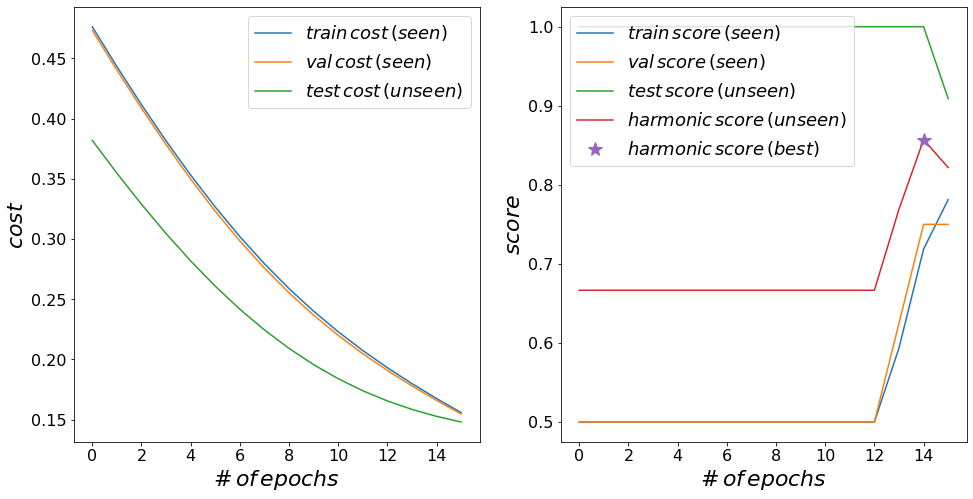

In [8]:
save_obj = ['.', '.', '2ornn', 'cost-score', outfilekey]
history_figure(rnn.history, save_obj=None)

In [ ]:
print_confmtx(rnn, dz, outfilekey, [0,1])

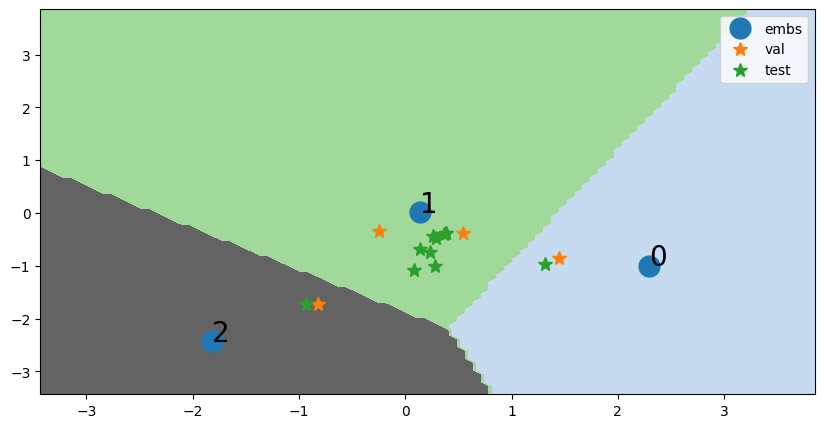

In [9]:
pca_vl, pca_ts, pca_emb, knn_pca= pca_denoising_preprocessing(rnn, dz, Xall, Y)
save_obj = ['.','.','2ornn', 'node-emb', outfilekey]
pca_denoising_figure(pca_vl ,pca_ts, pca_emb, knn_pca, labels, save_obj=None)

In [ ]:
p_train = p_val = p_test = None
for x, _, _, _ in dz.train:
    p_train = rnn.call(x)
for x, _, _, _ in dz.val:
    p_val = rnn.call(x)
for x, _, _, _ in dz.test:
    p_test = rnn.call(x)

concat = np.concatenate([Xall, p_train[0], p_val[0], p_test[0]])
mylist = labels_all+['train']*p_train[0].shape[0]+['val']*p_val[0].shape[0]+['test']*p_test[0].shape[0]

ediml = np.array([
    (i, l) for i, l in enumerate(mylist)
])
out = 'foo.tsv'
with open("./tensorboard_files/{}".format(out), "w") as foo:
    text = "idx\tlabel\n"
    for c in ediml:
        text += '\t'.join(c.tolist())
        text += '\n'
    foo.write(text)
    foo.close()

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard

log_dir="./tensorboard_files/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

weights = tf.Variable(concat)
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding"))


# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
# set tsv file
embedding.metadata_path = out
projector.visualize_embeddings(log_dir, config)

# ref: from tensorflow site

In [ ]:
%tensorboard --logdir=./tensorboard_files/ --host localhost --port 8882